# Trump or Troll
## Final Project: Shivam Jindal (sj2546) and Mayank Vanjani (mv1506)

Classify tweets sent by President Trump versus Russian trolls

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten
import keras.backend as K

Using TensorFlow backend.


In [2]:

df = pd.read_excel("TrumpTwitterAll.xlsx")
df2 = pd.read_csv("IRAhandle_tweets_1.txt")


trump_tweets_df is a dataframe containing all of the trump tweets from our dataset  
troll_tweets_df is a dataframe containing all of the troll tweets from our dataset

In [3]:
#df.head(5)
print(df.shape)
print(df2.shape)
print(df.columns)
print(df2.columns)

trump_tweets_df = df["Tweet"]
troll_tweets_df = df2["content"][:30078]

(30078, 5)
(243891, 21)
Index(['Date', 'Time', 'Tweet', 'Client', 'Client Simplified'], dtype='object')
Index(['external_author_id', 'author', 'content', 'region', 'language',
       'publish_date', 'harvested_date', 'following', 'followers', 'updates',
       'post_type', 'account_type', 'retweet', 'account_category',
       'new_june_2018', 'alt_external_id', 'tweet_id', 'article_url',
       'tco1_step1', 'tco2_step1', 'tco3_step1'],
      dtype='object')


In [4]:
trump_tweets_df.head(5)

0    If the press would cover me accurately & honor...
1    I am thrilled to nominate Dr. @RealBenCarson a...
2    their country (the U.S. doesn't tax them) or t...
3    Did China ask us if it was OK to devalue their...
4    .@FoxNews will be re-running "Objectified: Don...
Name: Tweet, dtype: object

In [5]:
troll_tweets_df.head(5)

0    "We have a sitting Democrat US Senator on tria...
1    Marshawn Lynch arrives to game in anti-Trump s...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN: President Trump dedicates Presidents ...
4    19,000 RESPECTING our National Anthem! #StandF...
Name: content, dtype: object

In [52]:
vectorizer = TfidfVectorizer( 
                max_df=0.5, # max doc freq (as a fraction) of any word to include in the vocabulary
                min_df=2,   # min doc freq (as doc counts) of any word to include in the vocabulary
                max_features=5000,           # max number of words in the vocabulary
                stop_words='english',         # remove English stopwords
                use_idf=True )        # use IDF scores

# first half are Trump tweets, second half are Troll tweets
all_my_tweeties = trump_tweets_df.append(troll_tweets_df)
all_my_tweeties.head(5)

X = vectorizer.fit_transform(all_my_tweeties)
X.shape

(60156, 5000)

In [53]:
pd.options.display.max_colwidth = 2000

print(all_my_tweeties[1000])

1000    Thank you American Legion Post 610- for hosting @Mike_Pence & I for a roundtable with labor leaders. #LaborDay #MAGA https://t.co/r0cwJlV38L
1000                                Buona domenica con la #buonalettura geopolitica della settimana  https://t.co/X17mpXcPfq https://t.co/YaZwFl0boc
dtype: object


In [54]:
doc_ind = 1000  # Index of an example document
xi = X[doc_ind,:].todense()
term_ind = xi.argsort()[:, ::-1]
xi_sort = xi[0,term_ind]
terms = vectorizer.get_feature_names()

for i in range(10):
    term = terms[term_ind[0,i]]
    tfidf = xi[0,term_ind[0,i]]
    print('{0:20s} {1:f} '.format(term, tfidf))

labor                0.428762 
mike_pence           0.412798 
hosting              0.394354 
maga                 0.355841 
leaders              0.342455 
post                 0.329780 
american             0.284062 
thank                0.217162 
https                0.098706 
foxandfriends        0.000000 


In [55]:
km = KMeans(n_clusters=2, init='k-means++', n_init=1, random_state=42)

In [56]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [57]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(2):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: http realdonaldtrump thanks trump great president thank https donald just people like don good obama run love america make time
Cluster 1: https enlist di на il la amp army video thank trump patriot mj4n1lcxvf usfa rt join gt trump2016 blacklivesmatter acapa


In [58]:
first_half = np.zeros(30078)
second_half = first_half+1

labels = np.append(first_half, second_half)

In [59]:
labelkm = km.labels_
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels,labelkm)

Csum = np.sum(C, axis=0)
Cnorm = C / Csum[None,:]
print(Cnorm)

[[0.67355768 0.07335441]
 [0.32644232 0.92664559]]


In [60]:
full_trump_text = " ".join([tweet.lower() for tweet in trump_tweets_df])

In [61]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
stopwords.update(["https"])

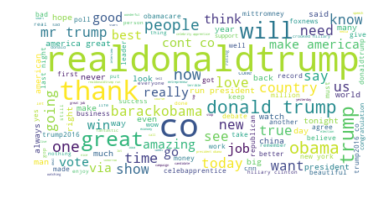

In [62]:

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(full_trump_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [63]:
full_troll_text = " ".join([tweet.lower() for tweet in troll_tweets_df])

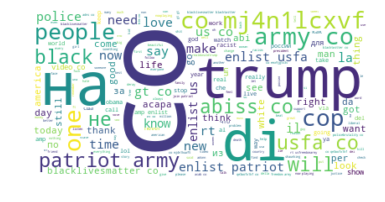

In [64]:

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(full_troll_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [77]:
Xtr, Xts, ytr, yts = train_test_split(X, labels, test_size=0.33, random_state=42)

In [89]:
K.clear_session()
nin = Xtr.shape[1]
print(nin)
nh = 100

nout = 1
model = Sequential()
model.add(Dense(units=1000, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=500, input_shape=(1000,), activation='sigmoid', name='hidden2'))
model.add(Dense(units=100, input_shape=(500,), activation='sigmoid', name='hidden3'))
model.add(Dense(units=nout, activation='sigmoid', name='output'))

5000


In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 1000)              5001000   
_________________________________________________________________
hidden2 (Dense)              (None, 500)               500500    
_________________________________________________________________
hidden3 (Dense)              (None, 100)               50100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 5,551,701
Trainable params: 5,551,701
Non-trainable params: 0
_________________________________________________________________


In [91]:
from keras import optimizers
opt = optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt,
             loss='binary_crossentropy', 
             metrics=['accuracy'])
hist = model.fit(Xtr.A, ytr, epochs=10, batch_size=100, validation_data=(Xts.A, yts))

Train on 40304 samples, validate on 19852 samples
Epoch 1/10
24100/40304 [================>.............] - ETA: 14s - loss: 0.4559 - acc: 0.7568

KeyboardInterrupt: 